# Chromatix 101

Chromatix is a library for simulating wave optics intended to be used for computational optics research. Chromatix allows for modeling of optical systems by composing together a set of optical elements in a manner similar to composing the layers of a neural network in a deep learning library. Much like a deep learning library, each optical element comes with support for autodifferentiation and runs on (potentially more than one) GPU, thanks to [JAX](https://github.com/google/jax). All of these make Chromatix a great fit for solving inverse problems in optics, such as phase retrieval or designing custom diffractive elements.

We'll go through a high level overview of Chromatix, demonstrating the two different styles Chromatix offers to model optical systems and highlighting a few of its capabilities along the way. We won't cover every detail of the library, but by the end of the notebook you should know where to look to find those details and also have an understanding of how all the pieces of the library fit together.

In [18]:
import equinox as eqx
import jax.numpy as jnp
import matplotlib as mpl

mpl.rc("font", family="Roboto")
import matplotlib.pyplot as plt
from jax import random
from jaxtyping import Array

import chromatix
import chromatix.functional as cx
from chromatix import Spectrum
from chromatix.elements import (
    BasicSensor,
    ClearThinSample,
    FFLens,
    PlaneWave,
)
from chromatix.systems import Microscope, Optical4FSystemPSF, OpticalSystem
from chromatix.utils import siemens_star

## Fields

### Creating a Field

Chromatix represents electric fields with the `Field` class. A `Field` describes not just the complex field in a 2D plane, but also keeps track of the spacing of the field (how far apart the centers of two pixels in a `Field` are) as well as the spectrum of the `Field`. `Field`s are further subclassed into `ScalarField` and `VectorField`, which either use the scalar approximation or the full vectorial simulation of a field respectively. There are also `ChromaticScalarField`s and `ChromaticVectorField`s for scalar and vectorial fields with multiple wavelengths (spectra). In this notebook, we'll mostly deal with `ScalarField`s for simplicity, but all the modeling that we show will also apply to `VectorField`s.

*Every* optical element in Chromatix deals with `Field`s, typically accepting an incoming `Field`, transforming it in some way, and then outputting the transformed `Field`. These transformations can include lenses, phase masks like spatial light modulators, aberrations, samples, propagations, etc.

Let's take a look at how to create a `Field` and go through its attributes and some of the operations you can perform:

In [2]:
# Create a monochromatic plane wave
field = cx.plane_wave(shape=(512, 512), dx=0.3, spectrum=0.532)
print(f"shape of field: {field.shape}")
print(f"spectrum: {field.spectrum}")
print(f"power (integrated intensity): {field.power}")

shape of field: (512, 512)
spectrum: MonoSpectrum(
  wavelength=Array([0.532], dtype=float32, weak_type=True),
  density=Array([1.], dtype=float32)
)
power (integrated intensity): [[1.0000002]]


Here we've called a Chromatix function to create a monochromatic plane wave. As you can see, defining a `Field` requires you to specify at least the 2D shape, the spacing of pixels (`dx`), and the wavelength of the `Field` (`spectrum`). The spectrum here is just a single wavelength, but the next snippet will show you how to handle a spectrum of multiple wavelengths in Chromatix. **Note that all of the units for pixel spacing and wavelengths must match, and this is not checked for you!** Here, we've input everything in microns.

As you can see, the shape of a `Field` is `(... height width)`. The first dimension, the ellipses, represent the fact that `Field`s can have zero or more "batch" dimensions (in this case we have zero). These can be used as a depth axis for 3D samples, time, a batch of different `Field`s, or any combination of the previous. Any operation provided by Chromatix will operate on all entries of the batch dimension in parallel. If you do *not* need the batch dimensions, they will *not* be created and you can work with a 2D `Field` in the simplest case! The other dimensions represent the height and width of the `Field` respectively.

Now let's create a more complicated `Field` that has a spectrum with multiple wavelengths:

In [3]:
# The same plane wave we made before:
field = cx.plane_wave(shape=(512, 512), dx=0.3, spectrum=0.532)
# Note the type of the Field tells you it is not chromatic (i.e. it is a single wavelength) and using the scalar approximation!
print("The first field we made was a", type(field))
# Now let's create a Field with multiple wavelengths:
field = cx.plane_wave(
    shape=(512, 512),
    dx=0.3,
    spectrum=Spectrum(wavelength=[0.532, 0.512], density=[0.6, 0.4]),
)
# Note the type of the Field tells you it is chromatic (multiple wavelengths) and using the scalar approximation!
print("The second field we made was a", type(field))
print(f"shape of field: {field.shape}")
print(f"spectrum: {field.spectrum}")
print(field.dx)
print(f"power (integrated intensity): {field.power}")

The first field we made was a <class 'chromatix.core.field.ScalarField'>
The second field we made was a <class 'chromatix.core.field.ChromaticScalarField'>
shape of field: (512, 512, 2)
spectrum: Spectrum(
  wavelength=Array([0.532, 0.512], dtype=float32),
  density=Array([0.6, 0.4], dtype=float32)
)
[[0.3 0.3]
 [0.3 0.3]]
power (integrated intensity): [[[1.0000002 1.0000002]]]


As you can see, by defining a `Spectrum` with multiple wavelengths, we can create a chromatic `Field`. Chromatix will simulate each wavelength independently in parallel. Because Chromatix keeps track of this information, it can do useful things automatically e.g. when calculating the intensity of a chromatic `Field`, Chromatix will take the densities of the wavelengths in the `Spectrum` into account.

You'll notice that the chromatic field has a new dimension now. This new dimension represents the spectrum of the field, i.e. these `ChromaticScalarField`s have the shape `(... height width wavelengths)`.

### Manipulating a Field

The actual JAX `Array` representing a `Field` can be found using `field.u`. However, as we've mentioned, every optical element described in Chromatix can handle `Field`s, so you can often avoid manipulating this array directly. For example, we can propagate a plane wave that has passed through a square aperture for 50 microns:

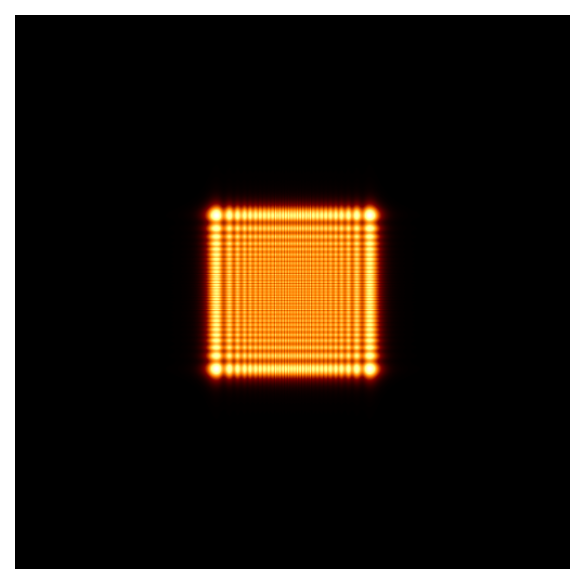

In [4]:
field = cx.plane_wave(shape=(512, 512), dx=0.3, spectrum=0.532)
field = cx.square_pupil(field, w=50.0)
field = cx.transfer_propagate(field, z=50.0, n=1.33, pad_width=0)
fig = plt.figure(dpi=150)
plt.imshow(field.intensity.squeeze(), cmap="afmhot")
plt.axis("off")
plt.show()

You can also manipulate a `Field` directly with most of the arithmetic operations available in Python (`+`, `-`, `*`, `**`, `/`, `//`, `@`), as long as what you're doing broadcasts as intended to the shape of the `Field`. This is intended for convenience, but keep in mind that **there are no checks performed when doing this** so you can create invalid results!

In [5]:
field = cx.plane_wave(shape=(512, 512), dx=0.3, spectrum=0.532)
print("field power:", field.power)
field *= 5
print("field * 5 power:", field.power)
field = 0 - field
print("0 - field power:", field.power)
field = field + jnp.ones((512, 512))
print("field + 1 power:", field.power)

field power: [[1.0000002]]
field * 5 power: [[25.000004]]
0 - field power: [[25.000004]]
field + 1 power: [[22081.953]]


### Visualizing a Field

For any `Field`, you can grab the intensity and phase in order to visualize it. Here's a plane wave propagating at an angle to the propagation axis, where intensity reveals nothing but phase shows you the angle of propagation:

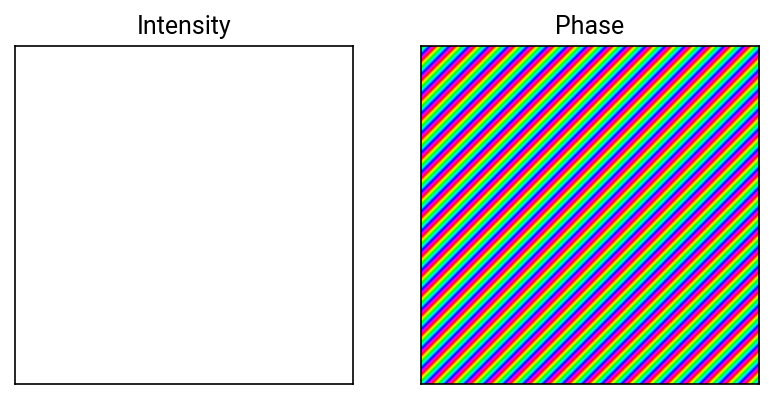

In [19]:
field = cx.plane_wave(
    shape=(512, 512),
    dx=0.3,
    spectrum=0.532,
    kykx=[1 / jnp.sqrt(2), 1 / jnp.sqrt(2)],  # This sets the angle of propagation
)
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=150)
ax = axes[0]
ax.imshow(
    field.intensity,
    cmap="gray",
    vmin=0,  # Visualized with vmin=0 to prevent small variations from dominating
)  # Intensity of first element of batch
ax.set_yticks([])
ax.set_xticks([])
ax.set_title("Intensity")
ax = axes[1]
ax.imshow(field.phase, cmap="hsv")  # Phase of first wavelength of first batch element
ax.set_yticks([])
ax.set_xticks([])
ax.set_title("Phase")
plt.show()

There are various other properties that Chromatix calculates over `Field` objects. For a complete list, check out the [properties of the `Field` in the full API documentation](https://chromatix.readthedocs.io/en/latest/api/field).

## Modeling optical systems in Chromatix

<div class="admonition warning">
  <p class="admonition-title">Warning</p>
  <p>
    A lot of the code we're showing here is calling JAX functions directly.
    Usually, you should use <code>jax.jit</code> to compile your code in order to
    make the simulation faster. Otherwise, you might find that a simulation
    appears to run very slowly. We'll show what it looks like to use
    <code>jax.jit</code> later on, but also see the
    <a href="https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html">JAX documentation</a>.
  </p>
</div>

So far, we've been looking at quick, one-off simulations. But that doesn't really make it very easy to optimize parameters of optical elements. Instead, we'd usually like to have some way to bundle a bunch of optical elements provided by Chromatix together into a system, so that initialization of optimizable parameters and other state is well handled and usable by neural network libraries like Equinox or Flax and optimizer libraries like Optax. We'll take a look at how to build simulations in Chromatix in two different styles: (1) as a sequence of optical elements, organized much like you would imagine placing physical elements, and (2) as an abstracted microscope that will take intensity measurements and simulate imaging of intensity samples using a point spread function. We'll talk about when you would want to use either style of simulation in their respective sections.

### Chromatix functional API vs Chromatix elements

Before we get to that, we'll have to talk about optical elements in Chromatix. Everything we've shown so far has been performed using functions. These form the functional API of Chromatix, which builds on top of `Field`s and defines many useful optical simulations that can handle them, as you've just seen. The rest of Chromatix is then built on top of these `Field`-manipulating functions.

That means that Chromatix provides both a functional core API, which is convenient for quick experimentation or visualization, as well as a set of element classes around these functions that assist with checking some constraints as well as managing parameters and state. This functional API is convenient for demonstrations, like this notebook. However, when you know what you want to simulate and are looking for a shorthand, convenient way to describe a system, e.g. when you want to optimize something, you can use Chromatix elements. Of course, you are free to use a combination of both in any way you please!

Chromatix elements are all Equinox `Module`s, meaning they act like neural network layers. The main difference between a normal neural network layer in JAX and a Chromatix element is that Chromatix elements act on `Field`s rather than just `Array`s. In fact, `Field`s are also `Module`s, mainly as a way to keep track of state associated with the complex field tensor in a way that plays nicely with JAX.

In [7]:
# Create a plane wave source as an element
plane_wave_source = PlaneWave(
    shape=(512, 512),
    dx=0.3,
    spectrum=0.532,
    kykx=jnp.zeros(2),
)
print(plane_wave_source)
field = (
    plane_wave_source()
)  # This is the same as the plane_wave function we used before!
print(
    f"field shape: {field.shape}\nfield spectrum: {field.spectrum}\nfield power: {field.power}"
)

PlaneWave(
  shape=(512, 512),
  dx=0.3,
  spectrum=0.532,
  power=1.0,
  amplitude=1.0,
  kykx=f32[2],
  pupil=None,
  scalar=True
)
field shape: (512, 512)
field spectrum: MonoSpectrum(
  wavelength=Array([0.532], dtype=float32, weak_type=True),
  density=Array([1.], dtype=float32)
)
field power: [[1.0000002]]


This doesn't look very useful for a single element, but can become useful if you have lots of elements passing `Field`s through each other or potentially combining optical models with other `Module`s like neural network layers. It's also useful to wrap up a simulation into a `Module` to keep track of a lot of the state of your simulation once you start to have lots of physical properties you need to keep track of to define your model. Often, we'll combine `Modules` and functions. See the [documentation on training](https://chromatix.readthedocs.io/en/latest/training/) and the [Holoscope example](https://chromatix.readthedocs.io/en/latest/examples/holoscope/) for more details.

### Modeling an optical system as a sequence of optical elements

Before we start, let's get some data that we want to use to simulate things with. We'll go with a simple Siemens star, which Chromatix has a utility function to generate:

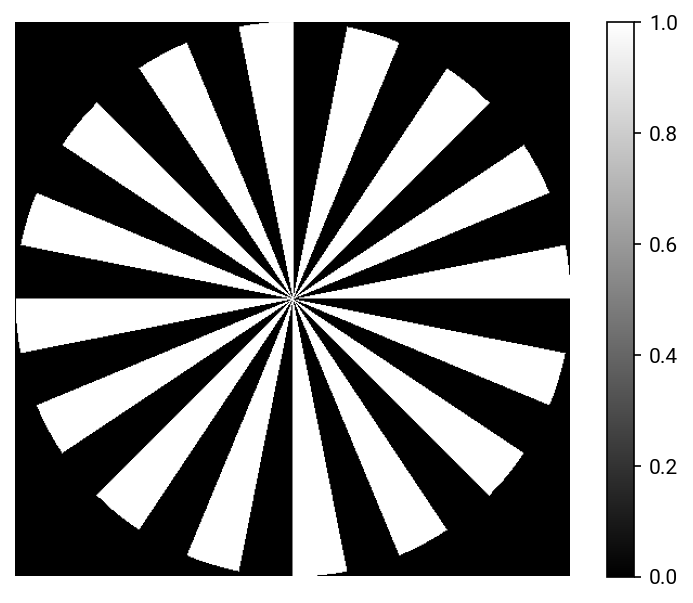

In [42]:
star = jnp.array(siemens_star(512))
fig = plt.figure(dpi=150)
plt.imshow(star, cmap="gray")
plt.axis("off")
plt.colorbar()
plt.show()

We'll simulate taking an image of this sample using a 4f system that has some defocus. We'll model the defocus using a phase mask. Let's also start with the most straightforward (and flexible!) way of creating a simulation. We'll build an `eqx.Module` and call the functions that we want directly. Let's see what that looks like:

In [49]:
class ImagingSystem(eqx.Module):
    sample: Array
    # Marking attributes static prevents them from being included in gradients
    # (or any JAX transformations, so be careful!)
    shape: tuple[int, int] = eqx.field(default=(512, 512), static=True)
    spacing: float = eqx.field(default=0.3, static=True)
    spectrum: float | Spectrum = eqx.field(default=0.532, static=True)
    f_objective: float = eqx.field(default=8e3, static=True)
    f_tube: float = eqx.field(default=8e3, static=True)
    n: float = eqx.field(default=1.0, static=True)
    NA: float = eqx.field(default=0.8, static=True)

    def __call__(self) -> Array:
        field = cx.plane_wave(shape=self.shape, dx=self.spacing, spectrum=self.spectrum)
        field = cx.thin_sample(
            field,
            absorption=jnp.zeros_like(self.sample),
            dn=self.sample,
            thickness=1.0,
        )
        field = cx.ff_lens(field, self.f_objective, self.n)
        field = cx.ff_lens(field, self.f_tube, self.n, self.NA)
        sensor = BasicSensor(
            shape=tuple(s // 2 for s in self.shape), spacing=field.central_dx * 2.0
        )
        image = sensor(field)
        return image

Here, we've modeled an imaging system that illuminates a thin phase sample with a plane wave, followed by a simple 4f system to image the result. We've included a sensor that for now we'll set to have no noise to keep things simple. The sensor also resamples the incoming field to its pixels, which we've defined to have half the resolution of the system.

The system is set up to interpret the given sample as a phase only term, i.e. the sample is interpreted as a refractive index distribution that will produce a phase contrast image.

In [58]:
# Creates the imaging system and initializes the system
# with the sample we want to image.
system = ImagingSystem(sample=star)
image = system()

/tmp/ipykernel_2262051/1429037307.py:23: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  sensor = BasicSensor(


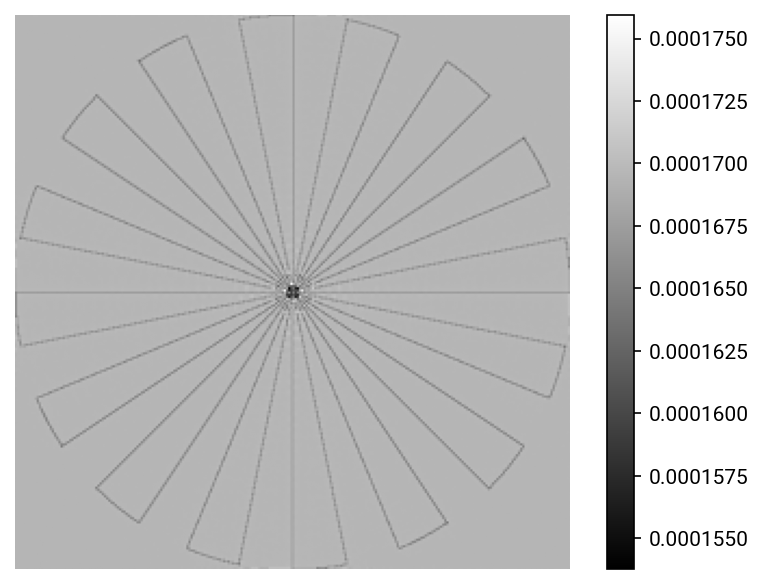

In [59]:
fig = plt.figure(dpi=150)
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.colorbar()
plt.show()

We see that we've got an image of our phase only sample illuminated by a plane wave. We could play with the angle of the plane wave and observe what happens to the resulting image, but first let's also take a look at how we can simplify the creation of the imaging system.

Most systems we will want to describe are a sequence of optical elements, such as illumination sources, samples, lenses, etc. Chromatix provides a convenient way to bundle these elements into a sequential system of optical elements: the `OpticalSystem`. This class allows you to provide a list of optical elements from Chromatix and have Chromatix *automatically* pass the field from element to element, returning to you the result. In this case, we've placed a sensor at the end so we'll receive an intensity array, but the result could just as easily have been a `Field`. Let's see what it looks like to define an `OpticalSystem` in Chromatix:

In [23]:
sample = star
system = OpticalSystem(
    [
        PlaneWave(shape=(512, 512), dx=0.3, spectrum=0.532),
        ClearThinSample(
            dn=sample,
            dx=0.3,
            thickness=1.0,
        ),
        FFLens(f=100.0, n=1.0),
        FFLens(f=100.0, n=1.0, NA=0.8),
        BasicSensor(shape=(256, 256), spacing=0.6),
    ]
)
image = system()

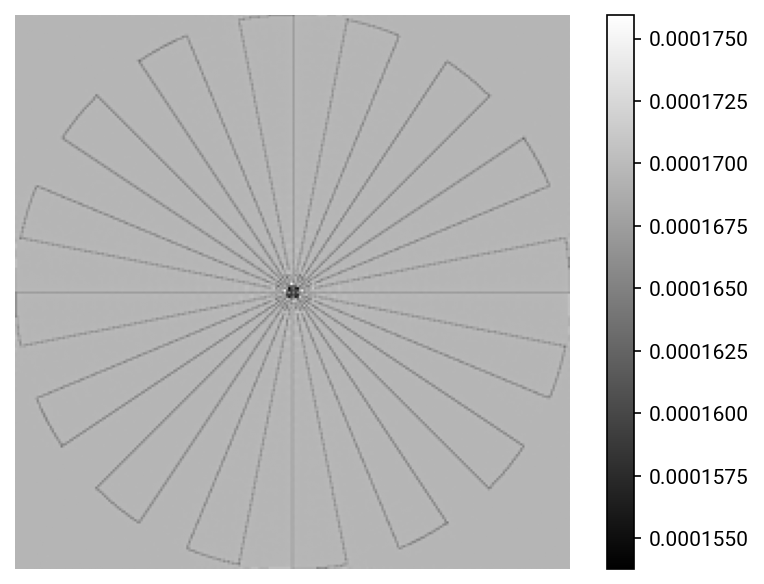

In [24]:
fig = plt.figure(dpi=150)
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.colorbar()
plt.show()

And we see that the result is exactly the same as what we simulated with our original `nn.Module` class. So in just a few lines of code, we described an optical system to Chromatix and got a simulated result!

But this style of describing a simulation has given us conciseness in exchange for flexibility. In the class we wrote ourselves, we could have called any function we wanted and manipulated the `Field` in any way we wanted. For example, you could use the functional Chromatix API in the class version to call `cx.thin_sample` instead of using the element, and then also take `sample` as an argument in order to simulate different samples every time.

Of course, the ability to write a custom `nn.Module` is available to you at any time. However, Chromatix also provides another convenient style for describing systems that are spatially invariant: `Microscope`s. Moreover, this style of simulation allows you to simulate an incoherent sample (e.g. a fluorescent sample) as opposed to the fully coherent simulation that we performed above.

### Modeling incoherent light in a spatially invariant microscope

A `Microscope` lets you plug in an `nn.Module` that computes the point spread function (PSF) of the sytem and also the sensor that you want to use. Given these two things, the `Microscope` computes the PSF, then performs a convolution between a given sample and the PSF. This would be appropriate for incoherent light and a spatially invariant microscope model. The `Microscope` takes samples as an input argument as opposed to an attribute, so you can image multiple samples with the same PSF more easily than how we imaged a sample above. Chromatix also provides common descriptions of system PSFs, e.g. the PSF for a 4f system. We'll use that system and initialize it with an aberrated phase mask to introduce some defocus to the system. Let's see what it looks like to define and image our Siemens star sample as an incoherent intensity sample (as if it were made of fluorescent particles):

In [39]:
microscope = Microscope(
    # Define the PSF for a 4f system
    system_psf=Optical4FSystemPSF(
        shape=(512, 512),
        spacing=6.5,  # microns
        f_tube=200e3,
        # We want to introduce some aberrations, which we can do
        # using the phase mask of the 4f system. We'll add some
        # defocus aberration using the Zernike polynomials, which
        # are built in to Chromatix.
        phase=chromatix.utils.zernike_aberrations(
            shape=(512, 512),
            spacing=200e3 * 0.532 / (512 * 6.5),  # Calculating spacing in Fourier plane
            wavelength=0.532,
            n=1.0,
            f=8e3,
            NA=0.5,
            ansi_indices=[0, 1, 2, 3, 4],
            coefficients=[0.2, 0.5, 0.1, 0.3, 0.1],
        ),
    ),
    # Define the sensor we want to image with
    sensor=BasicSensor(
        shape=(512, 512),
        spacing=6.5,
        shot_noise_mode="poisson",  # This time, we simulate shot noise
    ),
    f=8e3,
    n=1.0,
    NA=0.5,
    spectrum=0.532,
)
image = microscope(star * 500, 0, key=random.PRNGKey(5))
psf = microscope.psf(0).intensity

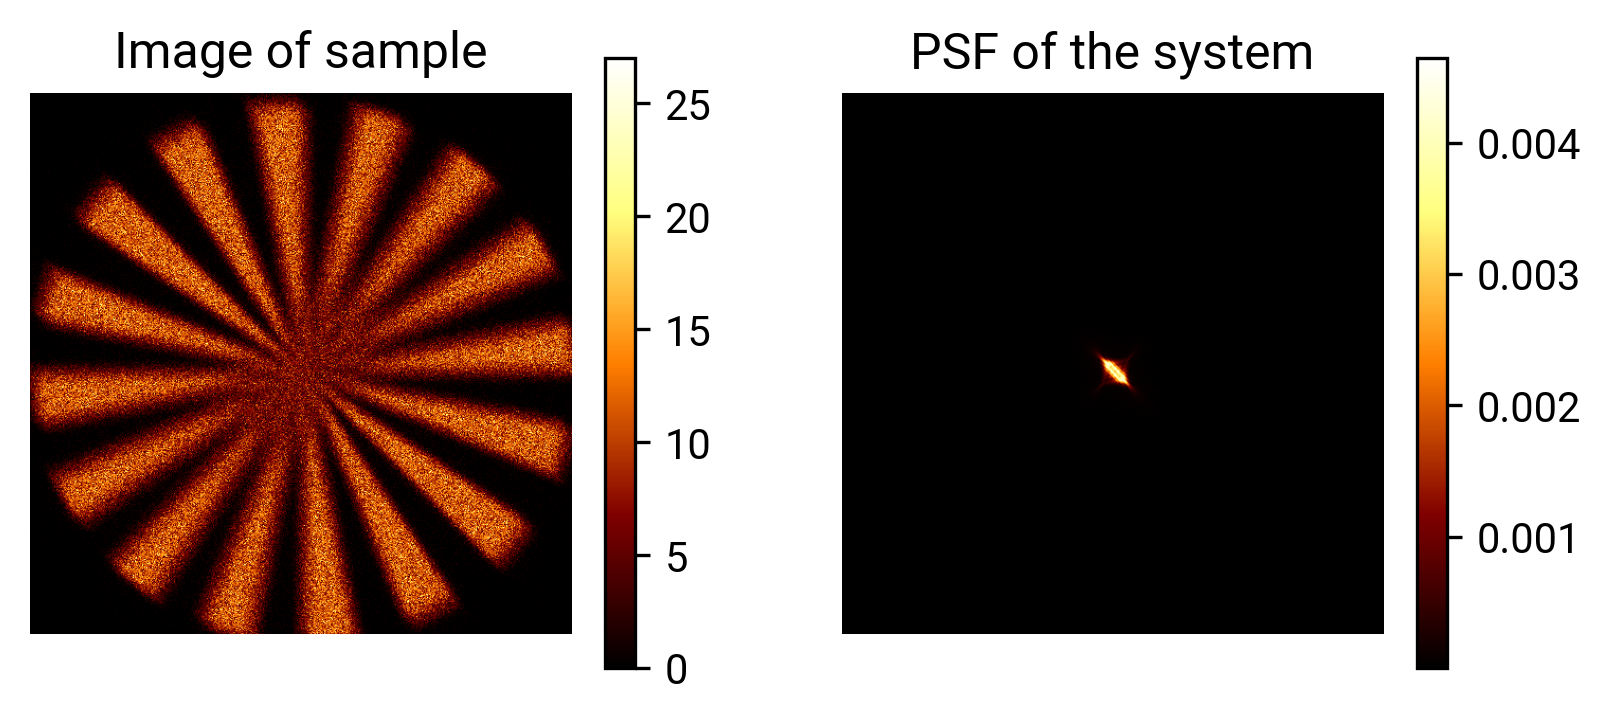

In [40]:
fig, axes = plt.subplots(ncols=2, nrows=1, dpi=300)
ax = axes[0]
im_handle = ax.imshow(image, cmap="afmhot")
fig.colorbar(im_handle, ax=ax, shrink=0.55)
ax.axis("off")
ax.set_title("Image of sample")
ax = axes[1]
im_handle = ax.imshow(psf**0.6, cmap="afmhot")
fig.colorbar(im_handle, ax=ax, shrink=0.55)
ax.axis("off")
ax.set_title("PSF of the system")
plt.show()

We see that with a relatively concise description of a `Microscope` we got a noisy, blurry image of our Siemens star! Note that in order to do this, we have to pass a noise key every time we call the model. We are also able to visualize the PSF of the system by calling the `microscope.psf` function. In the PSF visualization, we can see the effect of adding defocus aberration to the phase of the 4f system.

This style allows for the efficient simulation of incoherent imaging for systems with PSFs, which can be described with any `nn.Module` (though Chromatix attempts to provide the most common systems out of the box).

Chromatix also supports optimizing the parameters of these systems, e.g. the phase mask of the 4f system --- in fact it's really the main purpose of Chromatix. Take a look at the [documentation on optimization](https://chromatix.readthedocs.io/en/latest/training/) as well as some of [our examples](https://chromatix.readthedocs.io/en/latest/examples/dmd/) to see this optimization in action!